Let  $\phi:\mathbb{R}^d \to \mathbb{R}$ be a smooth function and consider $$\min_{a_k\in \mathbb{R},x_k\in \mathbb{R}^d} \| \sum_{i=1}^K a_k \phi(x_k) - y \|^2$$ 


We first consider the case of 1D Fourier sampling, that is, $\phi(x) = \frac{1}{\sqrt{2f_c+1}} \left(\exp(2\pi \sqrt{-1} x k)\right)_{k=-f_c,\ldots,f_c}$. 

Let us first define operators $\Phi$, its Jacobian $d\Phi$ and the ground truth.


In [1]:
import numpy as np
from numpy.matlib import repmat

d=1 #dimension

#define operators
fc=6
fq = np.arange(-fc, fc+1)
Phi = lambda t: np.exp(-2*np.pi*1j*fq[:,None]@t[None,:])/np.sqrt(2*fc+1)
dPhi = lambda t: (-2*np.pi*1j*fq[:,None])*np.exp(-2*np.pi*1j*fq[:,None]@t[None,:])/np.sqrt(2*fc+1)
 

#define ground truth
a = np.array([1,-2])
x = np.array([0.1,0.23])
y = Phi(x)@a


Rather than handling this directly, the idea of VarPro is to solve $\min_{x} f(x)$ with
$$
f(x) = \| \sum_{i=1}^K a[x]_k \phi(x_k) - y \|^2, \quad a[x] = \mathrm{argmin}_a \| \sum_{i=1}^K a_k \phi(x_k) - y \|^2
$$
Note that $a[x]$ is the solution to a least squares problem and is precisely
$$
a[k] = \Phi_x^{\dagger} y, \quad \Phi_x = [\phi(x_1), \cdots, \phi(x_K)].
$$
The function $f$ is differentiable with $\nabla f(x) = \left(a_k J_\phi(x_k)^\top [\Phi_x a[x] - y] \right)_k$ where $J_\phi$ denotes the Jacobian of $\phi$.

One can also add quadratic regularisation to solve
$\min_{x} f_\lambda(x)$ with
$$
f_\lambda(x) = \frac{\lambda}{2} \|x\|^2+ \frac{\lambda}{2} \|a[x]\|^2+\frac12 \| \sum_{i=1}^K a[x]_k \phi(x_k) - y \|^2, \quad a[x] = \mathrm{argmin}_a  \frac12 \| \sum_{i=1}^K a_k \phi(x_k) - y \|^2 + \frac{\lambda}{2} \|a\|^2
$$
and $a[x]$ can be computed in  closed form as
$$
a[k] = (\lambda I + \Phi_x^{*}\Phi_x)^{-1} \Phi_x^* y
$$

**References:**

Golub, G.H., Pereyra, V.: The differentiation of pseudoinverses and nonlinear least squares problems whose variables separate. SIAM Journal on Numerical Analysis 10, 413–432 (1973)

Golub, G.H., Pereyra, V.: Separable nonlinear least squares: The variable projection method and its applications. Inverse Problems 19(2), R1–R26 (2003)




In [2]:
from numpy import linalg 
from scipy import optimize

def VarPro(Phi, dPhi, y,lam,xinit,d):
    n = len(xinit)
    k=n//d
    def f_and_g(x):
        M = np.real( np.conjugate(Phi(x)).T@Phi(x)) +lam*np.eye(k)
        a = linalg.solve( M, np.real( np.conjugate(Phi(x)).T@ y))
        res = Phi(x)@a - y
        ad = repmat(a,d,1).flatten('F')
        grad = lam*x + ad*np.real( np.conjugate(dPhi(x)).T@res)
        fval = 0.5*linalg.norm(res)**2 + lam*np.dot(a,a)*0.5 + lam*np.dot(x,x)*0.5
        return fval,grad
    R = optimize.minimize(f_and_g, xinit, method='L-BFGS-B', jac=True)
    x = R.x
    M = np.real( np.conjugate(Phi(x)).T@Phi(x)) +lam*np.eye(k)
    a = linalg.solve( M, np.real( np.conjugate(Phi(x)).T@ y))
    return a, x

Run VarPro and display

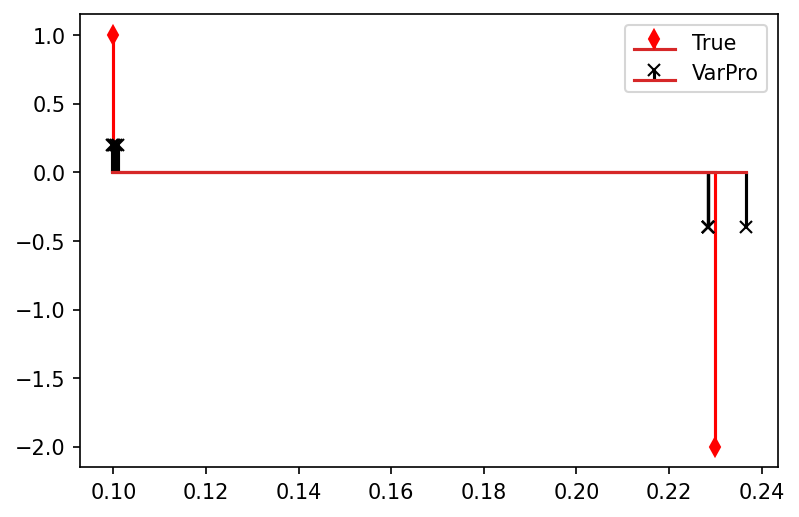

In [3]:
import matplotlib.pyplot as plt
plt.figure(dpi=150)

lam =0.01
N=10
xinit = np.random.rand(N*d,)*0.1
a_v, x_v = VarPro(Phi, dPhi, y,lam,xinit,d)

plt.stem(x%1, a, 'r',markerfmt=('rd'), label='True')
plt.stem(x_v%1, a_v, 'k',markerfmt=('kx'), label='VarPro')
plt.legend()
plt.show()


To obtain sparse solutions, we consider instead another variant of VarPro, where the inner problem is the Lasso, $\min_{x} f(x)$ with
$$
f(x) = \| \sum_{i=1}^K a[x]_k \phi(x_k) - y \|^2 + \lambda \|a[x]\|_1, \quad a[x] = \mathrm{argmin}_a \lambda \|a\|_1 + \| \sum_{i=1}^K a_k \phi(x_k) - y \|^2
$$
Now, $a[x]$ is the solution to a Lasso problem and *when this is unique*, the function $f$ is differentiable with $$\nabla f(x) = \left(a_k J_\phi(x_k)^\top [\Phi_x a- y] \right)_k$$ where $a = a[x_k]$ and $J_\phi$ denotes the Jacobian of $\phi$.

To compute $\nabla f(x)$, we need to solve a Lasso problem.  So, let's first define Lasso  solvers. We provide two options here, ISTA (Daubechies, Defrise, and Mol, An iterative thresholding algorithm for linear inverse
problems with a sparsity constraint, CPAM (2004)) or a BFGS solver ( Poon and Peyré. Smooth Bilevel Programming for Sparse Regularization. Neurips 2021):

In [4]:
def ISTA(AtA, Aty,lam, a = [],maxits = 1000):

    if not a:
        a =  Aty
    tau = 1/linalg.norm(AtA)
    for it in range(maxits):
        a = a - tau*AtA@a + tau*Aty
        a = np.sign(a)*np.maximum(np.abs(a)-tau*lam,np.zeros_like(a))
    return a

def bfgs_l1(AtA, Aty,lam):
    n= AtA.shape[0]
    def compute_grad(v):
        M = AtA*v[:,None]*v[None,:]+lam*np.eye(n)
        u = linalg.solve(M,v*Aty)
        grad = lam*v + u*(AtA@(u*v)-Aty)
        fval = -np.dot(Aty,u*v)+np.dot(AtA@(u*v),u*v)*0.5\
            +lam*np.dot(u,u)*.5+lam*np.dot(v,v)*.5
        return fval, grad
    
    v = np.random.rand(n,)
    
    R = optimize.minimize(compute_grad, v, method='L-BFGS-B', jac=True)
    v = R.x
    M = AtA*v[:,None]*v[None,:]+lam*np.eye(n)
    u = linalg.solve(M,v*Aty)
    return u*v


Define $\ell_1$ VarPro:

In [5]:

def VarPro_l1(Phi, dPhi, y,lam,xinit, d,inner='bfgs'):
    
    
    def f_and_g(x):
        Phix = Phi(x)
        X = np.real(np.conjugate( Phix ).T@Phix )
        Xty = np.real(np.conjugate( Phix ).T@ y)
        if inner=='bfgs':
            a = bfgs_l1(X, Xty,lam)
        else:
            a = ISTA(X, Xty,lam)
 
        res = Phix@a - y
        ad = repmat(a,d,1).flatten('F')
        grad = ad*np.real( np.conjugate(dPhi(x)).T@res)
        fval = 0.5*linalg.norm(res)**2 + lam*np.sum(np.abs(a))
        return fval,grad
    R = optimize.minimize(f_and_g, xinit, method='L-BFGS-B', jac=True)
    x = R.x
    Phix = Phi(x)
    X = np.real(np.conjugate( Phix ).T@Phix )
    Xty = np.real(np.conjugate( Phix ).T@ y)
    if inner=='bfgs':
        a = bfgs_l1(X, Xty,lam)
    else:
        a = ISTA(X, Xty,lam)
    return a, x

Run $\ell_1$ VarPro:

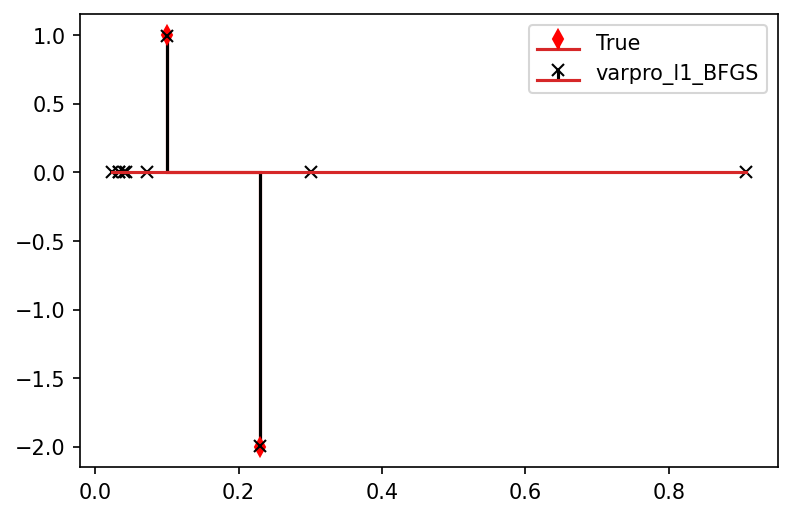

In [6]:
plt.figure(dpi=150)
#xinit = np.random.rand(N*d,)*0.1
a_v, x_v = VarPro_l1(Phi, dPhi, y,lam,xinit,d, inner='bfgs')

plt.stem(x%1, a, 'r',markerfmt=('rd'), label='True')
plt.stem(x_v%1, a_v, 'k',markerfmt=('kx'), label='varpro_l1_BFGS')

plt.legend()
plt.show()

In contrast, one could have directly solved $$\min_{a,x} \lambda \|a\|_1 +\frac12 \|\Phi_x a - y\|^2
$$
where the minimisation over is over $a,b\in\mathbb{R}_+^n$ and $x,z\in [0,1]^n$.

See the following reference for global convergence analysis of this problem:

Chizat, Lenaic, and Francis Bach. "On the global convergence of gradient descent for over-parameterized models using optimal transport." Advances in neural information processing systems 31 (2018).

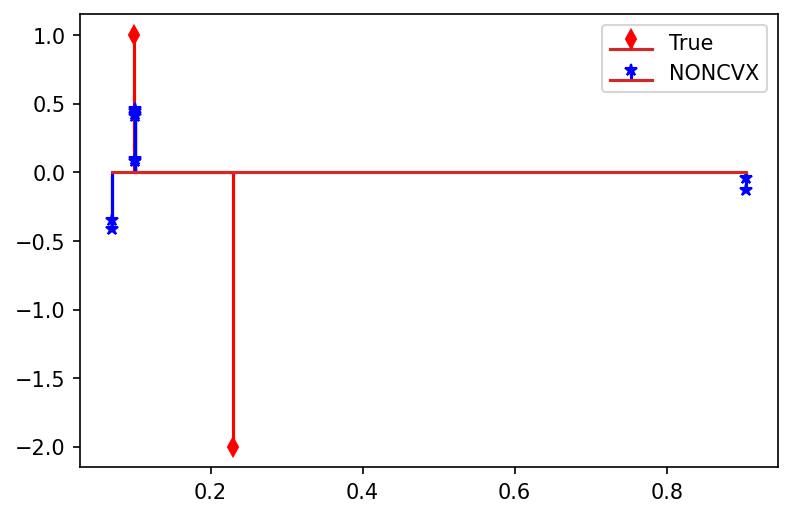

In [7]:
def Noncvx(Phi, dPhi, y,lam,axinit,d):
    
    n = len(axinit)//(d+1)
    def f_and_g(ax):
        a = ax[:n]
        x = ax[n:]
        M = Phi(x)
        res = M@a - y
        
        ga = np.real(np.conjugate( M ).T@res)  \
            + lam*np.sign(a)
        
        dM = dPhi(x)
        ad = repmat(a,d,1).flatten('F')
        gx = ad*np.real( np.conjugate(dM).T@res)
        f = 0.5*linalg.norm(res)**2 + lam*np.sum(np.abs(a))
        return f, np.concatenate((ga,gx))
    R = optimize.minimize(f_and_g, axinit, method='L-BFGS-B', jac=True)
    a = R.x[:n]
    x = R.x[n:]
    return a, x

#axinit = np.random.randn((d+1)*N,)*0.1
axinit = np.concatenate((np.random.randn(N,)*0.1, xinit))
a_, x_ = Noncvx(Phi, dPhi, y,lam,axinit,d)

plt.figure(dpi=150)

plt.stem(x%1, a, 'r',markerfmt=('rd'), label='True')
plt.stem(x_%1, a_, 'b',markerfmt=('b*'), label='NONCVX')


plt.legend()
plt.show()


**1 Homogeneous functions (e.g. the ReLU)**

**One positive Homogeneous functions (e.g. the ReLU)**

Suppose that  $\phi$ is  one-homogeneous , that is, $\phi(ax) = a\phi(x)$ for all positive scalars $a$. An example is the ReLU $\phi(x) = \max(x^\top z,0)$ for some $z\in \mathbb{R}^d$. Then, the least-squares VarPro approach directly corresponds to $\ell_1$ regularisation. Indeed, the absolute value has the variational form
$$
|x|  = \max_{uv = x} \frac12 u^2 + \frac12 v^2,
$$
so
 if $\phi$ is 1-homogeneous, minimising $$f(a,x) = \frac{\lambda}{2} \|a\|^2 + \frac{\lambda}{2} \|x\|^2 + \frac12 \| \sum_{i=1}^K a_k \phi(x_k) - y\|^2$$ is equivalent to minimising
$$
\min_{b,x}  \| \sum_{i=1}^K b_k \psi(x_k) - y \|^2+ \lambda \|b\|_1
$$
where $\psi(x) = \phi(x/\|x\|)$. As we saw above, numerically, when $\phi$ is not homogeneous (e.g. Fourier operator), the least squares formulation of VarPro does not lead to sparse solutions, but as can be observed here, for homogeneous $\phi$, all three particle approaches lead to sparse solutions.

See also https://francisbach.com/quest-for-adaptivity/ for a discussion VarPro for the ReLU.

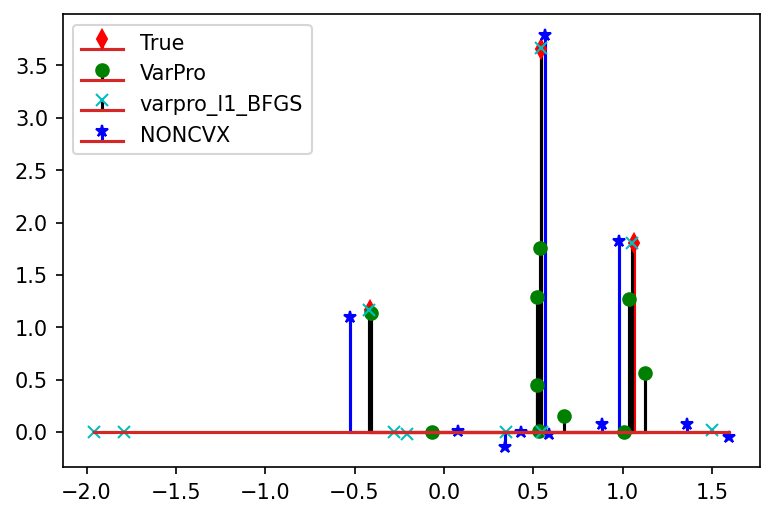

In [8]:
d=10
m=80
#for random data Z, define Phi and dPhi corresponding to the ReLU
Z = np.random.randn(m,d)

def Phi(Theta):
    Theta = Theta.reshape((-1,d))
    s = Theta.shape[0]

    Phi = np.maximum(Z@Theta.T,0)
    
    return Phi

def dPhi(Theta):
    Theta = Theta.reshape((-1,d))
    s = Theta.shape[0]
    ZT = Z@Theta.T>0
    zt = ZT[:,0]
    dPhiT = Z.T*zt[None,:]
    for i in range(1,s):
        zt = ZT[:,i]
        dPhiT = np.concatenate( (dPhiT, Z.T*zt[None,:]) )
    DPhi = dPhiT.T
    return DPhi

def normalise(a,x):
    x = x.reshape(-1,d)
    x_norm = np.sqrt(np.sum(x**2,1))
    x /= x_norm[:,None]
    a *= x_norm
    return a,x

#define ground truth
K = 3
a = np.random.randn(K,)
x = np.random.randn(K,d)

a,x = normalise(a,x)
y = Phi(x)@a

lam =0.1
N = 10

#least squares VarPro
xinit = np.random.randn(N*d,)*.1
a_v, x_v = VarPro(Phi, dPhi, y,lam,xinit,d)
a_v,x_v = normalise(a_v,x_v)

#l1 VarPro
a_vl1, x_vl1 = VarPro_l1(Phi, dPhi, y,lam,xinit,d, inner='bfgs')
a_vl1, x_vl1 = normalise(a_vl1, x_vl1)

#directly solving the nonconvex problem
axinit = np.concatenate((np.random.randn(N,)*0.1, xinit))
a_ncvx, x_ncvx = Noncvx(Phi, dPhi, y,lam,axinit,d)
a_ncvx, x_ncvx = normalise(a_ncvx, x_ncvx)


#display results
plt.figure(dpi=150)

plt.stem(np.sum(x,1), a, 'r',markerfmt=('rd'), label='True')
plt.stem(np.sum(x_v,1), a_v, 'k',markerfmt=('go'), label='VarPro')
plt.stem(np.sum(x_vl1,1), a_vl1, 'k',markerfmt=('cx'), label='varpro_l1_BFGS')
plt.stem(np.sum(x_ncvx,1), a_ncvx, 'b',markerfmt=('b*'), label='NONCVX')

plt.legend()
plt.show()

